# Porting an analysis from local to distributed

In this pair of notebooks, we will develop a prototype unsupervised analysis with sklearn and then port it to use Spark, as we might in real life.

<a href = "http://yogen.io"><img src="http://yogen.io/assets/logo.svg" alt="yogen" style="width: 200px; float: right;"/></a>


## K-means clustering using sklearn

Our starting point is a dataset, `~/Data/sales_segments.csv.gz`, which contains data for air reservations at segment level.

For each reservation, we get among others a `revenue_amount_seg` value, a `fuel_surcharge_amount_seg` value and a `bookings_seg` value. The first one represents the main amount paid to the airline and the second is referred to as 'tax', but reflects a different kind of revenue that in principle should be roughly proportional to the first kind. The third is the number of persons booked for the segment in question.

The rationale here is that the business side has detected that some of the segments are probably wrong and requested an automated way to detect suspicious segments based on their revenue / fuel_surcharge ratio.

How do you think we could do that in a scalable way?

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### First, inspect the data 

In [2]:
df = pd.read_csv('sales_segments.csv.gz', sep='^')

/home/dsc/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (40,44,45,47,48,57) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
pd.options.display.max_columns = None

In [4]:
df.sample(5)

,rloc,departure_date_seg,booking_date,freq_flyer_flag,creator_office_id,creator_iata_number,creator_gds_code,creator_city_code,creator_lat,creator_lon,creator_country_code,creator_continent_code,creator_channel_code,booking_status_code,cabin_code,booking_class_code,pos_office_id,pos_iata_number,pos_gds_code,pos_city_code,pos_lat,pos_lon,pos_country_code,pos_continent_code,pos_channel_code,board_point_seg,board_lat,board_lon,board_country_code,board_continent_code,off_point_seg,off_lat,off_lon,off_country_code,off_continent_code,num_legs,distance_seg,route,network,airline_code,flight_number,flight_type,revenue_source,estimated_flag,usage_board_point_seg,usage_off_point_seg,usage_flight_number,usage_date,non_currency_type,bookings_seg,rpk_seg,revenue_amount_seg,currency_code,fuel_surcharge_amount_seg,fuel_surcharge_currency_code,emd_count,emd_amount,emd_currency_code,total_outliers
1034809,X85SW9,2016-01-20,2016-01-19,False,MRUM12107,52269976.0,1A,MRU,-20.30000,57.58333,MU,Africa,Travel Agent,HK,Y,P,MRUM12107,52269976.0,1A,MRU,-20.30000,57.58333,MU,Africa,Travel Agent,RUN,-20.90083,55.53715,RE,Africa,MRU,-20.30000,57.58333,MU,Africa,1,223.206527,MRU-RUN,Africa,UU,128,I,LIFT (1A pror),False,RUN,MRU,128.0,2016-01-20,NaN,1,223,43.43,EUR,14.53,EUR,0,0.0,NaN,17.318831
865214,6L5FOP,2014-12-26,2014-11-18,False,RUNUU0760,66491106.0,UU,RUN,-20.90083,55.53715,RE,Africa,Airline,HK,Y,F,RUNUU0760,66491106.0,00,RUN,-20.90083,55.53715,RE,Africa,Airline,RUN,-20.90083,55.53715,RE,Africa,CDG,49.01278,2.55000,FR,Europe,1,9372.159277,CDG-RUN,Europe,UU,976,I,LIFT (1A pror),False,RUN,CDG,976.0,2014-12-26,NaN,1,9372,96.50,EUR,0.00,EUR,0,0.0,NaN,0.000000
1144858,6FWYR6,2014-07-05,2014-02-27,True,RUNUU08AB,66490782.0,UU,RUN,-20.90083,55.53715,RE,Africa,Electronic,HK,Y,N,RUNUU08AB,66490782.0,00,RUN,-20.90083,55.53715,RE,Africa,Electronic,RUN,-20.90083,55.53715,RE,Africa,CDG,49.01278,2.55000,FR,Europe,1,9372.159277,CDG-RUN,Europe,UU,976,I,LIFT (1A pror),False,RUN,CDG,976.0,2014-07-05,NaN,1,9372,490.63,EUR,224.37,EUR,0,0.0,NaN,207.347040
1215127,7OSR8W,2014-12-12,2014-12-12,False,RUNUU010C,66490771.0,UU,RUN,-20.90083,55.53715,RE,Africa,Airline,HK,Y,T,RUNUU010C,66490771.0,1A,RUN,-20.90083,55.53715,RE,Africa,Airline,CDG,49.01278,2.55000,FR,Europe,RUN,-20.90083,55.53715,RE,Africa,1,9372.159277,CDG-RUN,Europe,UU,977,I,LIFT (1A pror),False,CDG,RUN,977.0,2014-12-12,NaN,2,18744,439.00,EUR,365.72,EUR,0,0.0,NaN,400.825122
76412,5N6NBB,2014-07-13,2014-05-06,True,DZAUU0006,66480050.0,UU,DZA,-12.78339,45.25693,YT,Africa,Airline,HK,Y,E,DZAUU0006,66480050.0,1A,DZA,-12.78339,45.25693,YT,Africa,Airline,RUN,-20.90083,55.53715,RE,Africa,CDG,49.01278,2.55000,FR,Europe,1,9372.159277,CDG-RUN,Europe,UU,975,I,LIFT (1A pror),False,RUN,CDG,975.0,2014-07-13,NaN,5,46860,1580.55,EUR,990.70,EUR,0,0.0,NaN,1036.442820


In [5]:
df['currency_code'].unique()

array(['EUR'], dtype=object)

In [6]:
df['fuel_surcharge_currency_code'].unique()

array(['EUR'], dtype=object)

### Calculate KPIs

* "revenue" per person
* "tax" per person


In [7]:
df['revenue'] = df['revenue_amount_seg'] / df['bookings_seg']
df['tax'] = df['fuel_surcharge_amount_seg'] / df['bookings_seg']

### Inspect the distributions

(-20, 750)

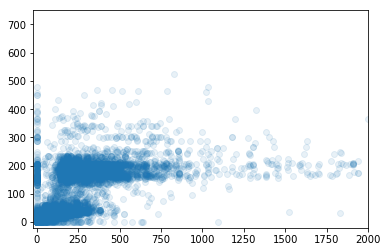

In [9]:
sample = df[['revenue', 'tax']].sample(10000)

plt.scatter(sample['revenue'], sample['tax'], alpha=.1)
plt.gca().set_xlim(-20, 2000)
plt.gca().set_ylim(-20, 750)

## Now for some learning!

It seems there are at least two or three groups of segments.

What we are going to do is to separate them into clusters with kmeans, then use the z-score as an outlier score.

#### Training a model with sklearn is quick and easy

We just use `.fit` and then `.predict`. As we'll see, this is very similar to Spark ML.

In [10]:
from sklearn.cluster import KMeans

clusterer = KMeans(n_clusters=3)

In [13]:
%time clusterer.fit(df[['revenue', 'tax']])

CPU times: user 10.8 s, sys: 218 ms, total: 11 s
Wall time: 3.23 s


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [14]:
clusterer.cluster_centers_

array([[  2.08796243e+02,   9.51820421e+01],
       [  7.77842455e+05,   3.01670000e+01],
       [  1.43154115e+05,   3.34175455e+01]])

(-20, 750)

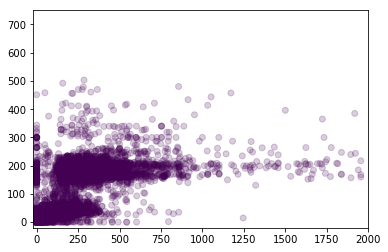

In [18]:
df['cluster'] = clusterer.labels_
sample = df[['revenue', 'tax', 'cluster']].sample(10000)

plt.scatter(sample['revenue'], sample['tax'], c=sample['cluster'], alpha=.2)
plt.gca().set_xlim(-20, 2000)
plt.gca().set_ylim(-20, 750)

### But, how do we know 3 clusters is the appropriate number?

We can use the [Elbow method][1]. For that, we will need a quality measure that we will plot for each clustering.

We will use the average distance of each point to its corresponding centroid.

[1]: https://en.wikipedia.org/wiki/Elbow_method_(clustering)

In [21]:
%%time

range_of_ks = range(3, 10)
clusterings = {}


for k in range_of_ks:
    print('Fitting %d clusters to the data...' % k)
    clusterer = KMeans(n_clusters=k)
    
    clusterer.fit(df[['revenue', 'tax']])
    clusterings[k] = clusterer
    

Fitting 3 clusters to the data...
Fitting 4 clusters to the data...
Fitting 5 clusters to the data...
Fitting 6 clusters to the data...
Fitting 7 clusters to the data...
Fitting 8 clusters to the data...
Fitting 9 clusters to the data...
CPU times: user 2min 12s, sys: 2.74 s, total: 2min 14s
Wall time: 45.7 s


Now we get each point's distance to its correponding centroid, which is the minimum for each row of the resulting matrix:

In [29]:
from scipy.spatial.distance import cdist

help(cdist)

Help on function cdist in module scipy.spatial.distance:

cdist(XA, XB, metric='euclidean', p=None, V=None, VI=None, w=None)
    Computes distance between each pair of the two collections of inputs.
    
    See Notes for common calling conventions.
    
    Parameters
    ----------
    XA : ndarray
        An :math:`m_A` by :math:`n` array of :math:`m_A`
        original observations in an :math:`n`-dimensional space.
        Inputs are converted to float type.
    XB : ndarray
        An :math:`m_B` by :math:`n` array of :math:`m_B`
        original observations in an :math:`n`-dimensional space.
        Inputs are converted to float type.
    metric : str or callable, optional
        The distance metric to use.  If a string, the distance function can be
        'braycurtis', 'canberra', 'chebyshev', 'cityblock', 'correlation',
        'cosine', 'dice', 'euclidean', 'hamming', 'jaccard', 'kulsinski',
        'mahalanobis', 'matching', 'minkowski', 'rogerstanimoto', 'russellrao',
  

In [34]:
a = np.array([(1,1),(2,1),(3,1)])
b = np.array([(9,1),(7,1)])

cdist(a,b)

array([[ 8.,  6.],
       [ 7.,  5.],
       [ 6.,  4.]])

In [37]:
points = df[['revenue', 'tax']]
points.shape

(1459121, 2)

In [38]:
centroids = clusterings[3].cluster_centers_
centroids.shape

(3, 2)

In [39]:
distances = cdist(points, centroids)

And we take either the sum or mean of the resultting vector:


In [40]:
np.mean(np.min(distances, axis=1))

189.70926172148199

Once we're sure it works, we can do it for k number of clusters:

In [41]:
distances = [cdist(points, clusterings[k].cluster_centers_) for k in clusterings]
average_distances_perclustering = [np.mean(np.min(d, axis=1)) for d in distances]

#### Let's plot the curve

In [42]:
%%time

range_of_ks = range(3, 14)
clusterings = {}


for k in range_of_ks:
    print('Fitting %d clusters to the data...' % k)
    clusterer = KMeans(n_clusters=k)
    
    clusterer.fit(df[['revenue', 'tax']])
    clusterings[k] = clusterer
    
distances = [cdist(points, clusterings[k].cluster_centers_) for k in clusterings]
average_distances_perclustering = [np.mean(np.min(d, axis=1)) for d in distances]

Fitting 3 clusters to the data...
Fitting 4 clusters to the data...
Fitting 5 clusters to the data...
Fitting 6 clusters to the data...
Fitting 7 clusters to the data...
Fitting 8 clusters to the data...
Fitting 9 clusters to the data...
Fitting 10 clusters to the data...
Fitting 11 clusters to the data...
Fitting 12 clusters to the data...
Fitting 13 clusters to the data...
CPU times: user 5min 5s, sys: 47.8 s, total: 5min 53s
Wall time: 2min 53s


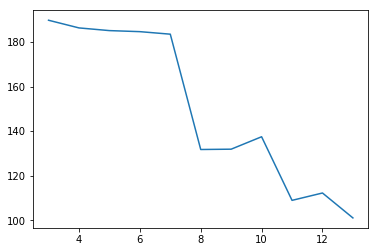

In [43]:
plt.plot(range_of_ks, average_distances_perclustering)

It was that easy! now let's see what we got:

(-20, 750)

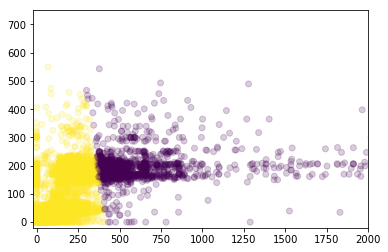

In [23]:
definitive_clustering = clusterings[8]

df['cluster'] = definitive_clustering.labels_

sample = df.sample(10000)

plt.scatter(sample['revenue'], sample['tax'], c=sample['cluster'], alpha=.2)
plt.gca().set_xlim(-20, 2000)
plt.gca().set_ylim(-20, 750)

### Z scores

Now we only need to calculate a z-score, so that we can score points as outliers or not outliers.



#### Calculate means and standard deviations in each direction for each cluster

In [24]:
stats_percluster = df.groupby('cluster')[['revenue', 'tax']].agg(['mean', 'std'])

In [25]:
stats_percluster

revenue                       tax            
                 mean           std        mean         std
cluster                                                    
0        6.339579e+02    422.574503  195.762750   53.810742
1        8.775004e+05  50236.153381   30.302000    1.808823
2        3.467367e+05  52460.589267  102.778125  112.845184
3        1.122863e+05  22148.322086   21.696947   65.610380
4        6.152070e+05  53170.300072   29.731250    1.542099
5        1.392156e+06           NaN   32.740000         NaN
6        1.334150e+02     94.599175   77.733926   79.067346
7        4.391545e+04  12642.971758   33.071603   34.736983

#### And annotate each point with the stats for its cluster

In [26]:
simple = df[['revenue', 'tax', 'cluster']]
simple.head()

,revenue,tax,cluster
0,33.560000,7.300000,6
1,61.200000,25.500000,6
2,71.868421,12.315789,6
3,27.116667,13.310000,6
4,0.000000,15.910000,6


In [27]:
annotated = simple.merge(stats_percluster, left_on='cluster', right_index=True)
annotated.sample(5)

/home/dani/anaconda3/envs/master-p3/lib/python3.6/site-packages/pandas/core/reshape/merge.py:551: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


,revenue,tax,cluster,"(revenue, mean)","(revenue, std)","(tax, mean)","(tax, std)"
1179323,99.00,52.39,6,133.414976,94.599175,77.733926,79.067346
402644,0.00,150.00,6,133.414976,94.599175,77.733926,79.067346
1110602,849.99,178.87,0,633.957936,422.574503,195.762750,53.810742
1077807,451.00,459.26,0,633.957936,422.574503,195.762750,53.810742
1141553,382.84,250.54,0,633.957936,422.574503,195.762750,53.810742


#### Now we are ready to calculate the z scores

In [28]:
annotated['z-revenue'] = (annotated['revenue'] - annotated[('revenue', 'mean')]) / annotated[('revenue', 'std')]
annotated['z-tax'] = (annotated['tax'] - annotated[('tax', 'mean')]) / annotated[('tax', 'std')]
annotated.head()

,revenue,tax,cluster,"(revenue, mean)","(revenue, std)","(tax, mean)","(tax, std)",z-revenue,z-tax
0,33.560000,7.300000,6,133.414976,94.599175,77.733926,79.067346,-1.055559,-0.890809
1,61.200000,25.500000,6,133.414976,94.599175,77.733926,79.067346,-0.763378,-0.660626
2,71.868421,12.315789,6,133.414976,94.599175,77.733926,79.067346,-0.650604,-0.827372
3,27.116667,13.310000,6,133.414976,94.599175,77.733926,79.067346,-1.123671,-0.814798
4,0.000000,15.910000,6,133.414976,94.599175,77.733926,79.067346,-1.410319,-0.781915


(-5, 5)

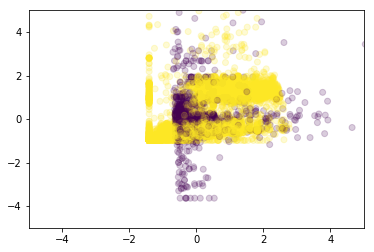

In [29]:
sample = annotated.sample(10000)

plt.scatter(sample['z-revenue'], sample['z-tax'], c=sample['cluster'], alpha=.2)
plt.gca().set_xlim(-5, 5)
plt.gca().set_ylim(-5, 5)

In [30]:
annotated['z-score'] = np.sqrt(annotated['z-revenue'] ** 2 + annotated['z-tax'] ** 2)
annotated.sample(5)

,revenue,tax,cluster,"(revenue, mean)","(revenue, std)","(tax, mean)","(tax, std)",z-revenue,z-tax,z-score
887389,176.72,178.57,6,133.414976,94.599175,77.733926,79.067346,0.457774,1.275319,1.354989
499413,51.65,8.57,6,133.414976,94.599175,77.733926,79.067346,-0.864331,-0.874747,1.229736
1205640,42.03,29.49,6,133.414976,94.599175,77.733926,79.067346,-0.966023,-0.610162,1.142584
638044,104.51,26.59,6,133.414976,94.599175,77.733926,79.067346,-0.305552,-0.646840,0.715377
1226623,158.99,20.32,6,133.414976,94.599175,77.733926,79.067346,0.270351,-0.726140,0.774835


In [31]:
annotated['outlier'] = annotated['z-score'] > 3
final = annotated[['revenue', 'tax', 'cluster', 'z-score', 'outlier']]
final.sample(5)

,revenue,tax,cluster,z-score,outlier
489398,219.50,195.67,6,1.747266,False
276433,199.02,158.72,6,1.236961,False
902790,380.50,170.02,0,0.767212,False
987126,0.00,19.20,6,1.592812,False
620235,44.64,41.22,6,1.045908,False


### How does this perform as an outlier detection method?

(-20, 750)

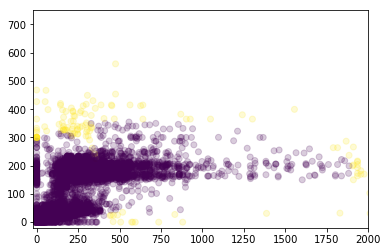

In [32]:
sample = final.sample(10000)

plt.scatter(sample['revenue'], sample['tax'], c=sample['outlier'], alpha=.2)
plt.gca().set_xlim(-20, 2000)
plt.gca().set_ylim(-20, 750)

In [33]:
df[final['outlier']].sample(5)

/home/dani/anaconda3/envs/master-p3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,rloc,departure_date_seg,booking_date,freq_flyer_flag,creator_office_id,creator_iata_number,creator_gds_code,creator_city_code,creator_lat,creator_lon,creator_country_code,creator_continent_code,creator_channel_code,booking_status_code,cabin_code,booking_class_code,pos_office_id,pos_iata_number,pos_gds_code,pos_city_code,pos_lat,pos_lon,pos_country_code,pos_continent_code,pos_channel_code,board_point_seg,board_lat,board_lon,board_country_code,board_continent_code,off_point_seg,off_lat,off_lon,off_country_code,off_continent_code,num_legs,distance_seg,route,network,airline_code,flight_number,flight_type,revenue_source,estimated_flag,usage_board_point_seg,usage_off_point_seg,usage_flight_number,usage_date,non_currency_type,bookings_seg,rpk_seg,revenue_amount_seg,currency_code,fuel_surcharge_amount_seg,fuel_surcharge_currency_code,emd_count,emd_amount,emd_currency_code,total_outliers,revenue,tax,cluster
205638,5Y7N98,2015-05-16,2015-05-15,False,RUNUU010C,66490771.0,UU,RUN,-20.90083,55.53715,RE,Africa,Airline,HK,Y,G,RUNUU010C,66490771.0,1A,RUN,-20.90083,55.53715,RE,Africa,Airline,CDG,49.01278,2.55000,FR,Europe,RUN,-20.90083,55.53715,RE,Africa,1,9372.159277,CDG-RUN,Europe,UU,974,I,LIFT (1A pror),False,CDG,RUN,974.0,2015-05-16,NaN,1,9372,261.99,EUR,328.11,EUR,0,0.0,NaN,174.044977,261.99,328.11,6
196181,2ICI99,2015-04-25,2015-03-04,False,PARAF08AA,20498170.0,AF,PAR,48.85341,2.34880,FR,Europe,Electronic,TK,?,N,PARAF08AA,20498170.0,00,PAR,48.85341,2.34880,FR,Europe,Electronic,RUN,-20.90083,55.53715,RE,Africa,DZA,-12.78339,45.25693,YT,Africa,1,1417.355675,DZA-RUN,Africa,AF,3251,I,LIFT (1A pror),False,RUN,DZA,3251.0,2015-04-25,NaN,1,1417,80.44,EUR,448.03,EUR,0,0.0,NaN,39.951724,80.44,448.03,6
68365,7P54RE,2014-06-26,2014-03-13,False,DZAUU01A4,66480094.0,UU,DZA,-12.78339,45.25693,YT,Africa,Airline,HK,Y,Y,DZAUU01A4,66480094.0,1A,DZA,-12.78339,45.25693,YT,Africa,Airline,RUN,-20.90083,55.53715,RE,Africa,CDG,49.01278,2.55000,FR,Europe,1,9372.159277,CDG-RUN,Europe,UU,976,I,LIFT (1A pror),False,RUN,CDG,975.0,2014-06-26,IT,1,9372,420.75,EUR,405.43,EUR,0,0.0,NaN,207.164060,420.75,405.43,0
99351,Z29UOC,2014-08-30,2014-08-18,False,RUNUU08AB,66490782.0,UU,RUN,-20.90083,55.53715,RE,Africa,Electronic,HK,Y,V,CDGUU000B,20492006.0,1A,PAR,48.85341,2.34880,FR,Europe,Airline,CDG,49.01278,2.55000,FR,Europe,RUN,-20.90083,55.53715,RE,Africa,1,9372.159277,CDG-RUN,Europe,UU,977,I,LIFT (1A pror),False,CDG,RUN,977.0,2014-08-30,NaN,1,9372,427.45,EUR,394.04,EUR,0,0.0,NaN,209.113605,427.45,394.04,0
323336,3Z42AN,2016-02-03,2015-10-03,False,GOAIG2144,38203303.0,1A,GOA,44.40632,8.93386,IT,Europe,Non IATA agent,HK,Y,G,GOAIG2144,38203303.0,00,GOA,44.40632,8.93386,IT,Europe,Non IATA agent,CDG,49.01278,2.55000,FR,Europe,RUN,-20.90083,55.53715,RE,Africa,1,9372.159277,CDG-RUN,Europe,UU,974,I,LIFT (1A pror),False,CDG,RUN,974.0,2016-02-03,IT,2,18744,437.32,EUR,671.84,EUR,0,0.0,NaN,498.074725,218.66,335.92,6


In [34]:
df[final['outlier'] & (df['creator_continent_code'] == 'Europe')].sample(5)

,rloc,departure_date_seg,booking_date,freq_flyer_flag,creator_office_id,creator_iata_number,creator_gds_code,creator_city_code,creator_lat,creator_lon,creator_country_code,creator_continent_code,creator_channel_code,booking_status_code,cabin_code,booking_class_code,pos_office_id,pos_iata_number,pos_gds_code,pos_city_code,pos_lat,pos_lon,pos_country_code,pos_continent_code,pos_channel_code,board_point_seg,board_lat,board_lon,board_country_code,board_continent_code,off_point_seg,off_lat,off_lon,off_country_code,off_continent_code,num_legs,distance_seg,route,network,airline_code,flight_number,flight_type,revenue_source,estimated_flag,usage_board_point_seg,usage_off_point_seg,usage_flight_number,usage_date,non_currency_type,bookings_seg,rpk_seg,revenue_amount_seg,currency_code,fuel_surcharge_amount_seg,fuel_surcharge_currency_code,emd_count,emd_amount,emd_currency_code,total_outliers,revenue,tax,cluster
1041764,48KUQ3,2016-02-08,2015-10-26,False,MRSA12157,20214972.0,1A,MRS,43.29695,5.38107,FR,Europe,Travel Agent,HK,Y,L,MRSA12157,20214972.0,1A,MRS,43.29695,5.38107,FR,Europe,Travel Agent,CDG,49.01278,2.55000,FR,Europe,RUN,-20.90083,55.53715,RE,Africa,1,9372.159277,CDG-RUN,Europe,UU,974,I,LIFT (1A pror),False,CDG,RUN,974.0,2016-02-08,IT,2,18744,295.44,EUR,671.84,EUR,0,0.0,NaN,459.243757,147.72,335.92,6
1065404,6NHQ9F,2016-05-29,2015-11-24,False,7B3,99999992.0,1G,GVA,46.20222,6.14569,CH,Europe,Travel Agent,HK,?,R,SWI1G2400,99999992.0,1G,GVA,46.20222,6.14569,CH,Europe,Travel Agent,MRU,-20.30000,57.58333,MU,Africa,CDG,49.01278,2.55000,FR,Europe,0,9429.170831,CDG-MRU,World,AF,463,I,Estimated from same route (same bkg and cabin ...,True,NaN,NaN,NaN,NaN,NaN,2,18858,2840.96,EUR,0.00,EUR,0,0.0,NaN,0.000000,1420.48,0.00,0
8439,YHNDBL,2014-01-14,2014-01-08,False,LILWL21FS,20209700.0,1A,LIL,50.63297,3.05858,FR,Europe,Non IATA agent,HK,Y,N,LILWL21FS,20209700.0,1A,LIL,50.63297,3.05858,FR,Europe,Non IATA agent,RUN,-20.90083,55.53715,RE,Africa,TMM,-18.14920,49.40234,MG,Africa,1,711.916222,RUN-TMM,Africa,UU,555,I,LIFT (1A pror),False,RUN,TMM,555.0,2014-01-14,NaN,1,711,467.63,EUR,17.03,EUR,0,0.0,NaN,35.143665,467.63,17.03,0
268371,23MHXO,2015-10-03,2015-09-14,False,TLNWL2101,20225693.0,1A,TLN,43.11667,5.93333,FR,Europe,Travel Agent,HK,W,W,TLNWL2101,20225693.0,1A,TLN,43.11667,5.93333,FR,Europe,Travel Agent,DZA,-12.78339,45.25693,YT,Africa,RUN,-20.90083,55.53715,RE,Africa,1,1417.355675,DZA-RUN,Africa,UU,202,I,LIFT (1A pror),False,DZA,RUN,202.0,2015-10-03,IT,1,1417,568.35,EUR,27.46,EUR,0,0.0,NaN,36.813465,568.35,27.46,0
80998,8M3HJU,2014-07-23,2014-06-29,False,PARA12415,20260155.0,1A,PAR,48.85341,2.34880,FR,Europe,Travel Agent,HK,Y,T,PARA12415,20260155.0,1A,PAR,48.85341,2.34880,FR,Europe,Travel Agent,RUN,-20.90083,55.53715,RE,Africa,HAH,-11.53591,43.27420,KM,Africa,1,1671.336586,HAH-RUN,Africa,UU,256,I,LIFT (1A pror),False,RUN,HAH,256.0,2014-07-23,NaN,1,1671,98.82,EUR,532.42,EUR,0,0.0,NaN,42.481818,98.82,532.42,6


### Appendix: saving models in sklearn

It's easy and fast with the `joblib` module.

In [36]:
import joblib

joblib.dump(definitive_clustering, 'mysupermodel.pkl')
my_reconstituted_model = joblib.load('mysupermodel.pkl')
my_reconstituted_model

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

## OK, let's move this to a more public place: the cluster!